# Pop dyn tests

In [1]:
import numpy as np
import pandas as pd
from typing import List, Text, Optional

from rl4fisheries import Msy, ConstEsc, CautionaryRule, AsmEnv
from rl4fisheries.envs.asm_fns import get_r_devs

In [15]:
config = {'s':0.86, 'noiseless': False, 'flat_harv_vul': False}
env = AsmEnv(config=config)
_ = env.reset()

In [16]:
def simulate_ep(env, agent, other_vars: Optional[List[Text]] = []):   
    simulation = {
        't': [],
        'surv_b_obs': [],
        'bare_surv_b_obs': [], 
        'mean_wt_obs': [],
        'act': [],
        'rew': [],
        'total_pop': [],
        'newborns': [],
        'non_random_newb': [],
        **{var_name: [] for var_name in other_vars}
    }
    obs, _ = env.reset()
    for t in range(env.Tmax):
        act, _ = agent.predict(obs)
        new_obs, rew, term, trunc, info = env.step(act)
        #
        simulation['t'].append(t)
        simulation['surv_b_obs'].append(
            env.bound * (obs[0]+1)/2
        )
        simulation['bare_surv_b_obs'].append(
            obs[0]
        )
        simulation['mean_wt_obs'].append(
            (
                env.parameters["min_wt"]
                + (env.parameters["max_wt"] - env.parameters["min_wt"])
                * (obs[1]+1)/2
            )
        )
        simulation['act'].append(act[0])
        simulation['rew'].append(rew)
        simulation['total_pop'].append(np.sum(env.state))
        simulation['newborns'].append(env.state[0])
        simulation['non_random_newb'].append(
            env.parameters["bha"] * env.ssb / (1 + env.parameters["bhb"] * env.ssb)
        )
        for var_name in other_vars:
            simulation[var_name].append(getattr(env, var_name))
        #
        obs = new_obs
    #
    return simulation

In [17]:
def expand_state(age_cls):
    def wrapped(row):
        return row.state[age_cls]
    return wrapped

def add_state_columns(df, env):
    df_inner = df.copy()
    for age_cls in range(len(env.state)):
        df_inner[f'age_{age_cls:02d}_b'] = df_inner.apply(expand_state(age_cls), axis=1)
    return df_inner
    

## No Harvest

In [18]:
trivp = Msy(env = env, mortality=0)
trivial_ep = pd.DataFrame(simulate_ep(AsmEnv(config=config), trivp, other_vars=['ssb', 'surv_vul_b', 'harv_vul_b', 'state']))

In [19]:
# trivial_ep.head()

In [20]:
trivial_ep = add_state_columns(trivial_ep, env)
melted_triv_ep = trivial_ep[['t', *[f'age_{i:02d}_b' for i in range(20)]]].melt(id_vars='t')

In [21]:
def prepare_for_altair(df):
    df = add_state_columns(df, env)
    melted_df = df[['t', *[f'age_{i:02d}_b' for i in range(20)]]].melt(id_vars='t')
    melted_df['population'] = melted_df['variable']
    melted_df['biomass'] = melted_df['value']
    return melted_df[['t', 'population', 'biomass']]

<Axes: title={'center': 'populations'}, xlabel='t'>

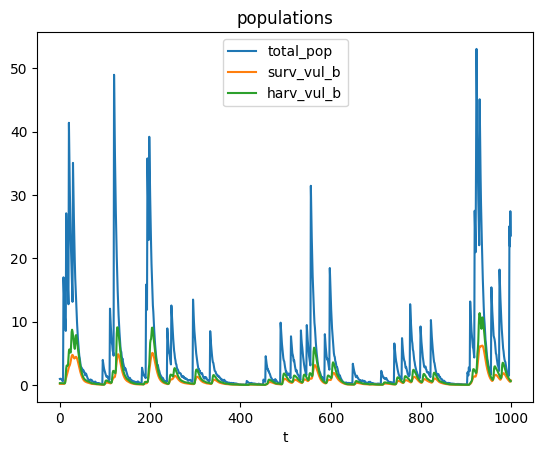

In [22]:
trivial_ep.plot(x='t', y = ['total_pop', 'surv_vul_b', 'harv_vul_b'], title='populations')

In [13]:
# %pip install altair
# %pip install vega_datasets

In [14]:
import altair as alt

triv_population = prepare_for_altair(trivial_ep)

triv_population_short = triv_population[triv_population.t < 100]

alt.Chart(triv_population_short).mark_area().encode(
    x="t:T",
    y="biomass:Q",
    color="population:N"
)

alt.Chart(...)

## Escapement

In [74]:
escp = ConstEsc(env, escapement = 0.008)
esc_ep = pd.DataFrame(simulate_ep(AsmEnv(config=config), escp, other_vars=['ssb', 'surv_vul_b', 'harv_vul_b', 'state']))

<Axes: title={'center': 'populations'}, xlabel='t'>

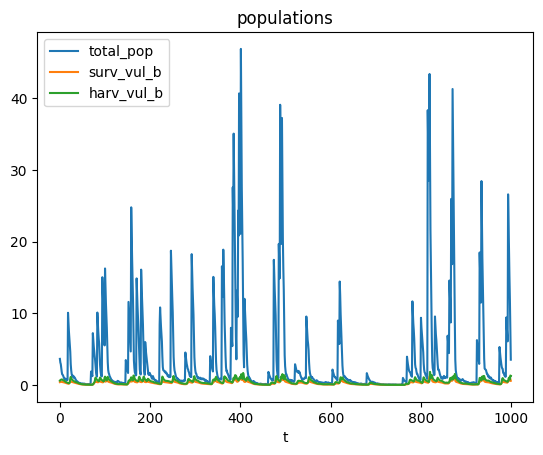

In [75]:
# esc_ep.plot(x='t', y = ['total_pop'], title='total population')
# esc_ep.plot(x='t', y = ['non_random_newb'], title='non-random newborns')
# esc_ep.plot(x='t', y = ['ssb'], title='Fished ssb')
# esc_ep.plot(x='t', y = ['newborns'], title='newborns', logy=True)
# esc_ep.plot(x='t', y = ['act'], title='actions')
# esc_ep.plot(x='t', y = ['surv_b_obs'], title='surv_b_obs')
esc_ep.plot(x='t', y = ['total_pop', 'surv_vul_b', 'harv_vul_b'], title='populations')

In [76]:
esc_population = prepare_for_altair(esc_ep)

esc_population_short = esc_population[triv_population.t < 100]

alt.Chart(esc_population_short).mark_area().encode(
    x="t:T",
    y="biomass:Q",
    color="population:N"
)

alt.Chart(...)

## MSY

In [77]:
msyp = Msy(env = env, mortality=0.057)
msy_ep = pd.DataFrame(simulate_ep(AsmEnv(config=config), msyp, other_vars=['ssb', 'surv_vul_b', 'harv_vul_b', 'state']))

<Axes: title={'center': 'populations'}, xlabel='t'>

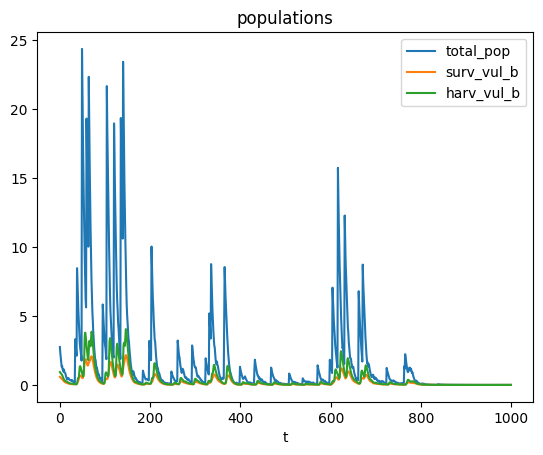

In [78]:
msy_ep.plot(x='t', y = ['total_pop', 'surv_vul_b', 'harv_vul_b'], title='populations')

In [79]:
msy_population = prepare_for_altair(msy_ep)

msy_population_short = msy_population[msy_population.t < 100]

alt.Chart(msy_population_short).mark_area().encode(
    x="t:T",
    y="biomass:Q",
    color="population:N"
)

alt.Chart(...)

<Axes: xlabel='age'>

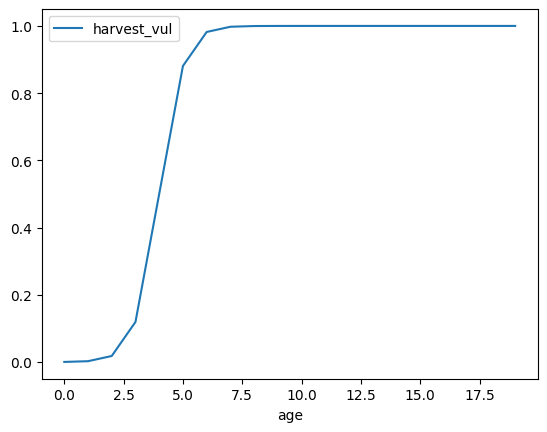

In [40]:
df = pd.DataFrame({
    'age': list(range(20)),
    'harvest_vul': env.parameters['harvest_vul']
})
df.plot(x='age')